In [1]:
import cabinetry

We start by configuring the output from `cabinetry`. It uses the `logging` module to send messages at different verbosity levels. This customization is optional, and you can also use the `logging` module directly for further customization. The `set_logging` function just sets up a verbose default.

In [2]:
cabinetry.set_logging()

## The configuration file

The configuration file is the central place to configure `cabinetry`.
Let's have a look at the example configuration file used in this notebook.

In [3]:
cabinetry_config = cabinetry.configuration.load("config_ntuples.yml")
cabinetry.configuration.print_overview(cabinetry_config)

INFO - cabinetry.configuration - opening config file config_ntuples.yml
INFO - cabinetry.configuration - the config contains:
INFO - cabinetry.configuration -   3 Sample(s)
INFO - cabinetry.configuration -   1 Regions(s)
INFO - cabinetry.configuration -   1 NormFactor(s)
INFO - cabinetry.configuration -   3 Systematic(s)


The configuration file is split into four different blocks of settings. There are general settings:

In [4]:
cabinetry_config["General"]

{'Measurement': 'minimal_example',
 'POI': 'Signal_norm',
 'HistogramFolder': 'histograms/',
 'InputPath': 'inputs/{SamplePath}'}

The list of phase space regions (channels), in this case we are considering just a single one:

In [5]:
cabinetry_config["Regions"]

[{'Name': 'Signal_region',
  'Variable': 'jet_pt',
  'Filter': 'lep_charge > 0',
  'Binning': [200, 300, 400, 500, 600]}]

A list of samples, including data:

In [6]:
cabinetry_config["Samples"]

[{'Name': 'Data',
  'Tree': 'pseudodata',
  'SamplePath': 'data.root',
  'Data': True},
 {'Name': 'Signal',
  'Tree': 'signal',
  'SamplePath': 'prediction.root',
  'Weight': 'weight',
  'DisableStaterror': True},
 {'Name': 'Background',
  'Tree': 'background',
  'SamplePath': 'prediction.root',
  'Weight': 'weight'}]

A list of normalization factors:

In [7]:
cabinetry_config["NormFactors"]

[{'Name': 'Signal_norm', 'Samples': 'Signal', 'Nominal': 1, 'Bounds': [0, 10]}]

And finally a list of systematic uncertainties. In this case there are three systematic uncertainties:

In [8]:
cabinetry_config["Systematics"]

[{'Name': 'Luminosity',
  'Up': {'Normalization': 0.05},
  'Down': {'Normalization': -0.05},
  'Type': 'Normalization'},
 {'Name': 'Modeling',
  'Up': {'SamplePath': 'prediction.root', 'Tree': 'background_varied'},
  'Down': {'Symmetrize': True},
  'Samples': 'Background',
  'Type': 'NormPlusShape'},
 {'Name': 'WeightBasedModeling',
  'Up': {'Weight': 'weight_up'},
  'Down': {'Weight': '0.7*weight'},
  'Samples': 'Background',
  'Type': 'NormPlusShape'}]

Regions, samples, normalization factors and systematics all can be identified by their names.

## Creating template histograms from ntuples

We use the `templates` module to create all histograms needed to build the workspace defined in the configuration file.

In [9]:
cabinetry.templates.build(cabinetry_config, method="uproot")

DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - Signal_region_Signal has empty bins: [0]
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Signal.npz
DEBUG - cabinetry.route -     reading sample Background
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background.npz
DEBUG - cabinetry.route -       variation Modeling Up
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background_Modeling_Up.npz
DEBUG - cabinetry.route -       variation WeightBasedModeling Up
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background_WeightBasedModeling_Up.n

The histograms are saved to the folder specified under `HistogramFolder` in the `General` settings in the configuration file.
In this case, this folder is `histograms/`:

In [10]:
!ls histograms/

Signal_region_Background.npz
Signal_region_Background_Modeling_Up.npz
Signal_region_Background_WeightBasedModeling_Down.npz
Signal_region_Background_WeightBasedModeling_Up.npz
Signal_region_Data.npz
Signal_region_Signal.npz


It can be useful to apply additional post-processing after building template histograms.
Such processing can for example replace ill-defined statistical uncertainties in empty bins by zero.
It is also performed via the `templates` module:

In [11]:
cabinetry.templates.postprocess(cabinetry_config)

DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Data_modified.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - Signal_region_Signal has empty bins: [0]
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Signal_modified.npz
DEBUG - cabinetry.route -     reading sample Background
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background_modified.npz
DEBUG - cabinetry.route -       variation Modeling Up
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background_Modeling_Up_modified.npz
DEBUG - cabinetry.route -       variation WeightBasedModeling Up
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region

New histograms have now appeard in the `histograms/` folder.
These "modified" histograms include the changes applied by the postprocessor.

In [12]:
!ls histograms/

Signal_region_Background.npz
Signal_region_Background_Modeling_Up.npz
Signal_region_Background_Modeling_Up_modified.npz
Signal_region_Background_WeightBasedModeling_Down.npz
Signal_region_Background_WeightBasedModeling_Down_modified.npz
Signal_region_Background_WeightBasedModeling_Up.npz
Signal_region_Background_WeightBasedModeling_Up_modified.npz
Signal_region_Background_modified.npz
Signal_region_Data.npz
Signal_region_Data_modified.npz
Signal_region_Signal.npz
Signal_region_Signal_modified.npz


## Optional: reading existing template histograms

Besides providing ntuples that first need to be turned into histograms, it is also possible to provide existing histograms to `cabinetry`.
The configuration options for this are slightly different, since less information is needed to read an existing histogram.

The following loads a `cabinetry` configuration using histogram inputs, collects all provided histograms (storing them in the format used internally by `cabinetry` for further processing) and applies post-processing.
The resulting histograms are equivalent to those created when reading the provided ntuples.

In [13]:
cabinetry_config_histograms = cabinetry.configuration.load("config_histograms.yml")
cabinetry.templates.collect(cabinetry_config_histograms, method="uproot")
cabinetry.templates.postprocess(cabinetry_config)

INFO - cabinetry.configuration - opening config file config_histograms.yml
DEBUG - cabinetry.route -   in region Signal_region
DEBUG - cabinetry.route -     reading sample Data
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Data.npz
DEBUG - cabinetry.route -     reading sample Signal
DEBUG - cabinetry.route -       variation Nominal
WARNING - cabinetry.histo - Signal_region_Signal has empty bins: [0]
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Signal.npz
DEBUG - cabinetry.route -     reading sample Background
DEBUG - cabinetry.route -       variation Nominal
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background.npz
DEBUG - cabinetry.route -       variation Modeling Up
DEBUG - cabinetry.histo - saving histogram to histograms/Signal_region_Background_Modeling_Up.npz
DEBUG - cabinetry.route -       variation WeightBasedModeling Up
DEBUG - cabinetry.histo - savin

## Workspace building

Next, we build a `pyhf` workspace and serialize it to a file.
The `workspace` module takes care of this task.

In [14]:
workspace_path = "workspaces/example_workspace.json"
ws = cabinetry.workspace.build(cabinetry_config)
cabinetry.workspace.save(ws, workspace_path)

INFO - cabinetry.workspace - building workspace
DEBUG - cabinetry.workspace - adding NormFactor Signal_norm to sample Signal in region Signal_region
DEBUG - cabinetry.workspace - adding OverallSys Luminosity to sample Signal in region Signal_region
DEBUG - cabinetry.workspace - adding OverallSys Luminosity to sample Background in region Signal_region
DEBUG - cabinetry.workspace - adding OverallSys and HistoSys Modeling to sample Background in region Signal_region
DEBUG - cabinetry.workspace - normalization impact of systematic Modeling on sample Background in region Signal_region is 0.800
DEBUG - cabinetry.workspace - adding OverallSys and HistoSys WeightBasedModeling to sample Background in region Signal_region
INFO - pyhf.workspace - Validating spec against schema: workspace.json
DEBUG - cabinetry.workspace - saving workspace to workspaces/example_workspace.json


## Model structure

It can be helpful to visualize the modifier structure of the statistical model we have built to catch potential issues.
The `visualize.modifier_grid` showcases the information about which modifiers (indicated by color) act on which region and sample when a given parameter (on the horizontal axis) is varied.
To split this visualization from one table per region to one table per sample, use `split_by_sample=True`.

We need the fit model (containing the probability density function) from the workspace for the visualization, which we get from the workspace object.
We will also extract data from it (observed bin yields and including auxiliary data for auxiliary measurements, see the HistFactory documentation https://cds.cern.ch/record/1456844), which we will use in the next step.

INFO - pyhf.workspace - Validating spec against schema: workspace.json
INFO - pyhf.pdf - Validating spec against schema: model.json
INFO - pyhf.pdf - adding modifier Modeling (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier WeightBasedModeling (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Signal_norm (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier Luminosity (1 new nuisance parameters)
INFO - pyhf.pdf - adding modifier staterror_Signal_region (4 new nuisance parameters)
INFO - cabinetry.visualize.utils - saving figure as figures/modifier_grid.pdf


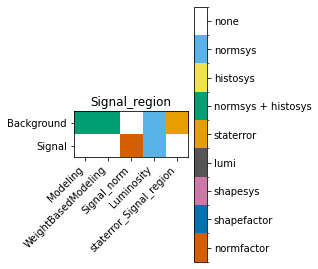

In [15]:
ws = cabinetry.workspace.load(workspace_path)
model, data = cabinetry.model_utils.model_and_data(ws)
cabinetry.visualize.modifier_grid(model)

## Fitting

With the workspace built, we can perform a maximum likelihood fit.
The results for the fitted parameters are reported.
The `cabinetry.model_utils.model_and_data` function has an `asimov` keyword argument, which we can set to `True` to instead study the expected performance with an Asimov dataset.

In [16]:
fit_results = cabinetry.fit.fit(model, data)

INFO - cabinetry.fit - performing maximum likelihood fit
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 18.54                      │              Nfcn = 330              │
│ EDM = 1.04e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴───────

We can also visualize the fit results.
Below are the pulls:

INFO - cabinetry.visualize.utils - saving figure as figures/pulls.pdf


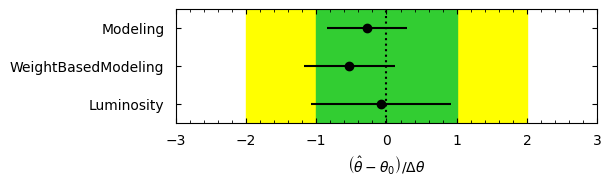

In [17]:
cabinetry.visualize.pulls(fit_results, exclude=["Signal_norm"])

We excluded the `"Signal_norm"` parameter, which does not have an associated constraint term in our fit model. The result for it was reported above in the fit output:
```
INFO - cabinetry.fit - Signal_norm                =  1.6895 +/- 0.9388
```
We can also look at the correlation between parameters:

INFO - cabinetry.visualize.utils - saving figure as figures/correlation_matrix.pdf


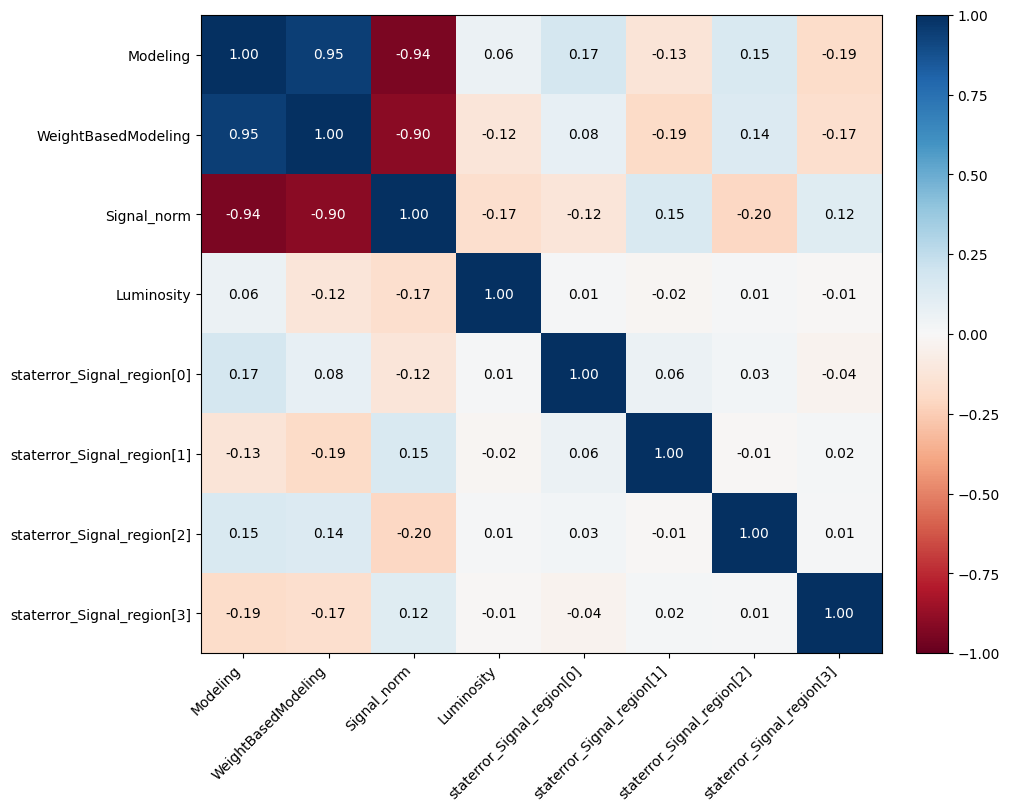

In [18]:
cabinetry.visualize.correlation_matrix(fit_results)

These visualizations were also saved as `.pdf` figures in the `figures/` folder.

## Visualizing templates

What did we fit?
The `visualize` module also contains functionality to plot data/MC distributions: `visualize.data_mc`.
We first need to create a model prediction, which is achieved with `model_utils.prediction`.
By default this creates the pre-fit model, but the optional `fit_results` argument allows to create the model corresponding to a given best-fit configuration.

The `config` keyword argument of `visualize.data_mc` is optional, but required for correct horizontal axis labels, since the observable and bin edges are not part of the `pyhf` workspace.
Since this argument is optional, you can use `cabinetry.visualize.data_mc` with any workspace: it does not matter whether it was created with `cabinetry` or otherwise, since you do not need a configuration file.

`visualize.data_mc` returns a list of dictionaries, we can extract a figure from there to further customize it.

DEBUG - cabinetry.model_utils - total stdev is [[69, 58.3, 38.2, 45.3]]
DEBUG - cabinetry.model_utils - total stdev per channel is [137]
INFO - cabinetry.visualize.utils - saving figure as figures/Signal_region_prefit.pdf


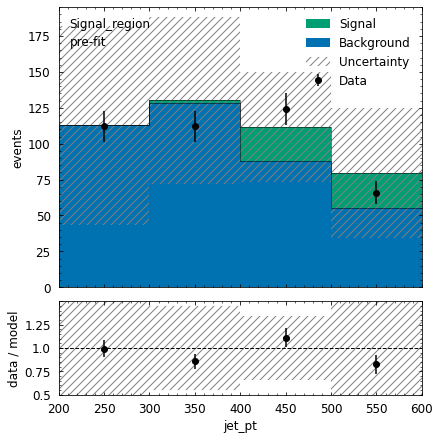

In [19]:
model_pred = cabinetry.model_utils.prediction(model)
figures = cabinetry.visualize.data_mc(model_pred, data, config=cabinetry_config)

This figure is also again saved in the `figures/` folder, like all figures in general.

To demonstrate figure customization, let's use $\LaTeX$ for the horizontal axis label. We can save the modified figure as well by using `.savefig()`.

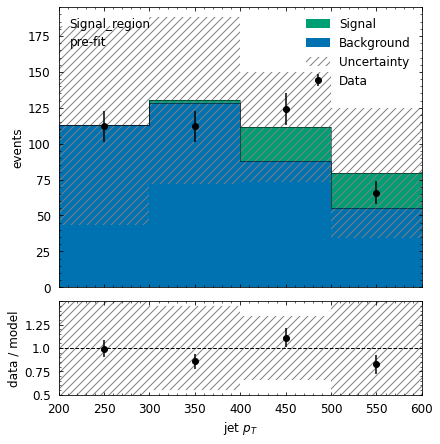

In [20]:
ratio_panel = figures[0]["figure"].get_axes()[1]
ratio_panel.set_xlabel("jet $p_T$")
figures[0]["figure"]  # show figure again

Yield tables can also be created from a model prediction, and compared to data.
Optional keyword arguments control whether yields per bin are shown (`per_bin=True`, default) and whether bins summed per region are shown (`per_channel=True`, disabled by default).
The yield table is also saved to disk by default, in a format customizable via the `table_format` argument.

In [21]:
_ = cabinetry.tabulate.yields(model_pred, data)

INFO - cabinetry.tabulate - yields per bin for pre-fit model prediction:
╒════════════╤═════════════════╤════════════════╤════════════════╤═══════════════╕
│ sample     │ Signal_region   │                │                │               │
│            │ bin 1           │ bin 2          │ bin 3          │ bin 4         │
╞════════════╪═════════════════╪════════════════╪════════════════╪═══════════════╡
│ Background │ 112.74 ± 69.04  │ 128.62 ± 58.33 │ 88.11 ± 38.06  │ 55.25 ± 45.20 │
├────────────┼─────────────────┼────────────────┼────────────────┼───────────────┤
│ Signal     │ 0.00 ± 0.00     │ 1.59 ± 0.08    │ 23.62 ± 1.18   │ 24.55 ± 1.23  │
├────────────┼─────────────────┼────────────────┼────────────────┼───────────────┤
│ total      │ 112.74 ± 69.04  │ 130.21 ± 58.34 │ 111.72 ± 38.21 │ 79.79 ± 45.29 │
├────────────┼─────────────────┼────────────────┼────────────────┼───────────────┤
│ data       │ 112.00          │ 112.00         │ 124.00         │ 66.00         │
╘════════════╧

We can also have a look at the table we saved to disk.
Other supported formats include `"html"` and `"latex"`. 

In [22]:
!cat tables/yields_per_bin_pre-fit.txt

sample      Signal_region    Signal_region    Signal_region    Signal_region
            bin 1            bin 2            bin 3            bin 4
----------  ---------------  ---------------  ---------------  ---------------
Background  112.74 ± 69.04   128.62 ± 58.33   88.11 ± 38.06    55.25 ± 45.20
Signal      0.00 ± 0.00      1.59 ± 0.08      23.62 ± 1.18     24.55 ± 1.23
total       112.74 ± 69.04   130.21 ± 58.34   111.72 ± 38.21   79.79 ± 45.29
data        112.00           112.00           124.00           66.00


We can also take a look at the post-fit model.

DEBUG - cabinetry.model_utils - total stdev is [[13.2, 7.2, 7.06, 7.73]]
DEBUG - cabinetry.model_utils - total stdev per channel is [20.7]
INFO - cabinetry.visualize.utils - saving figure as figures/Signal_region_postfit.pdf


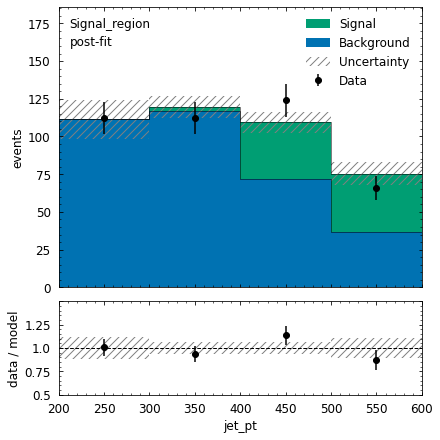

In [23]:
model_pred_postfit = cabinetry.model_utils.prediction(model, fit_results=fit_results)
_ = cabinetry.visualize.data_mc(model_pred_postfit, data, config=cabinetry_config)

## Beyond simple maximum likelihood fitting 

`cabinetry` provides a range of useful utilities for statistical inference besides simple maximum likelihood fitting.
To start, let's look at ranking nuisance parameters by their impact on the parameter of interest.

In [24]:
ranking_results = cabinetry.fit.ranking(model, data)

INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 18.54                      │              Nfcn = 330              │
│ EDM = 1.04e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 18.535252 at b

DEBUG - cabinetry.fit - -2 log(L) = 19.662341 at best-fit point
DEBUG - cabinetry.fit - POI is 0.644792, difference to nominal is -0.948973
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 19.51                      │              Nfcn = 222              │
│ EDM = 6.61e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │

DEBUG - cabinetry.fit - -2 log(L) = 19.532562 at best-fit point
DEBUG - cabinetry.fit - POI is 1.465410, difference to nominal is -0.128355
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 19.54                      │              Nfcn = 270              │
│ EDM = 2.95e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │

DEBUG - cabinetry.fit - -2 log(L) = 19.539799 at best-fit point
DEBUG - cabinetry.fit - POI is 1.404519, difference to nominal is -0.189246
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 19.53                      │              Nfcn = 270              │
│ EDM = 0.000111 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │

The previous cell ran a lot of maximum likelihood fits to calculate all the input needed to rank nuisance parameters. We will visualize them next.

INFO - cabinetry.visualize.utils - saving figure as figures/ranking.pdf


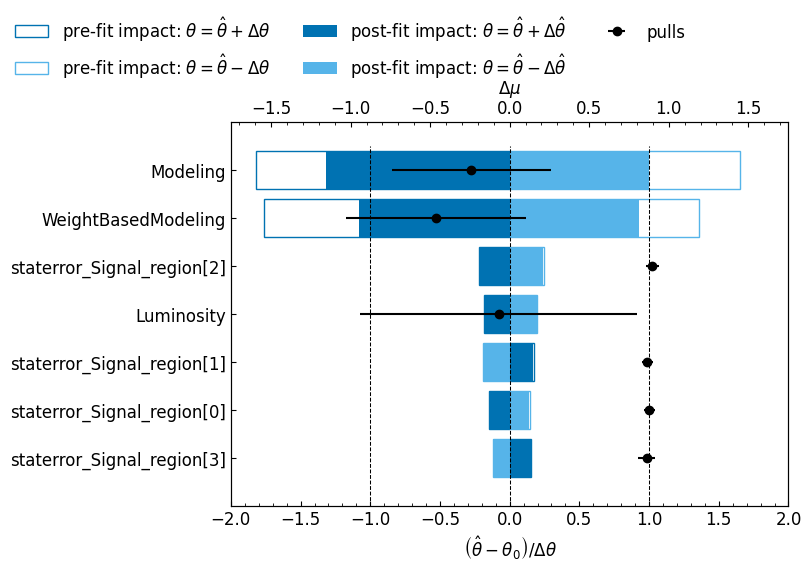

In [25]:
cabinetry.visualize.ranking(ranking_results)

The results are contained in the `ranking_results` object. It is a simple named tuple, we can have a look at its content.

In [26]:
ranking_results

RankingResults(bestfit=array([-0.27529071, -0.52768031, -0.07941828,  1.00123651,  0.9883001 ,
        1.02156575,  0.98291109]), uncertainty=array([0.5683095 , 0.64774531, 0.99100884, 0.04114037, 0.03842981,
       0.04690882, 0.06096864]), labels=['Modeling', 'WeightBasedModeling', 'Luminosity', 'staterror_Signal_region[0]', 'staterror_Signal_region[1]', 'staterror_Signal_region[2]', 'staterror_Signal_region[3]'], prefit_up=array([-1.59374151, -1.54765161, -0.15926218, -0.13181116,  0.1539161 ,
       -0.19255584,  0.13292265]), prefit_down=array([ 1.44607054,  1.18796859,  0.17392294,  0.12542056, -0.16732123,
        0.21435221, -0.10254726]), postfit_up=array([-1.15331231, -0.94897302, -0.15797906, -0.12835492,  0.14900244,
       -0.18924588,  0.13366721]), postfit_down=array([ 0.87514006,  0.81331124,  0.1723961 ,  0.12218725, -0.16147842,
        0.2109206 , -0.10294653]))

We can also perform likelihood scans for parameters.
The example below performs a scan for the `Modeling` nuisance parameter.

In [27]:
scan_results = cabinetry.fit.scan(model, data, "WeightBasedModeling")

INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 18.54                      │              Nfcn = 330              │
│ EDM = 1.04e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
DEBUG - cabinetry.fit - -2 log(L) = 18.535252 at b

DEBUG - cabinetry.fit - -2 log(L) = 18.696625 at best-fit point
DEBUG - cabinetry.fit - performing fit with WeightBasedModeling = -0.009
INFO - cabinetry.fit - Migrad status:
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 19.22                      │              Nfcn = 200              │
│ EDM = 7.7e-07 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ No

The resulting figure looks like this:

INFO - cabinetry.visualize.utils - saving figure as figures/scan_WeightBasedModeling.pdf


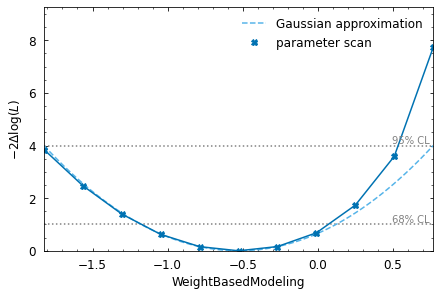

In [28]:
cabinetry.visualize.scan(scan_results)

With `cabinetry.fit.limit`, we can evaluate observed and expected 95% confidence level upper parameter limits.
The implementation uses Brent bracketing to efficiently find the `CLs=0.05` crossing points.

In [29]:
limit_results = cabinetry.fit.limit(model, data)

INFO - cabinetry.fit - calculating 95% confidence level upper limit for Signal_norm
INFO - cabinetry.fit - determining observed upper limit
DEBUG - cabinetry.fit - Signal_norm = 0.1000, observed CLs = 0.9184
DEBUG - cabinetry.fit - Signal_norm = 10.0000, observed CLs = 0.0000
DEBUG - cabinetry.fit - Signal_norm = 9.4610, observed CLs = 0.0000
DEBUG - cabinetry.fit - Signal_norm = 4.7805, observed CLs = 0.0001
DEBUG - cabinetry.fit - Signal_norm = 2.4403, observed CLs = 0.1975
DEBUG - cabinetry.fit - Signal_norm = 4.1886, observed CLs = 0.0012
DEBUG - cabinetry.fit - Signal_norm = 3.3144, observed CLs = 0.0287
DEBUG - cabinetry.fit - Signal_norm = 2.8773, observed CLs = 0.0862
DEBUG - cabinetry.fit - Signal_norm = 3.1526, observed CLs = 0.0446
DEBUG - cabinetry.fit - Signal_norm = 3.1049, observed CLs = 0.0504
DEBUG - cabinetry.fit - Signal_norm = 3.1099, observed CLs = 0.0498
INFO - cabinetry.fit - successfully converged after 11 steps
INFO - cabinetry.fit - observed upper limit: 3.109

Again, the results are visualized:

INFO - cabinetry.visualize.utils - saving figure as figures/limit.pdf


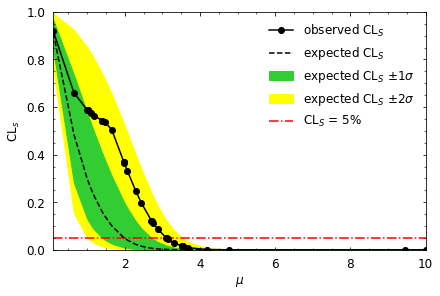

In [30]:
cabinetry.visualize.limit(limit_results)

The observed limits are above the expected limits.
We can calculate the discovery significance with `cabinetry.fit.significance`:

In [31]:
significance_results = cabinetry.fit.significance(model, data)

INFO - cabinetry.fit - calculating discovery significance for Signal_norm
INFO - cabinetry.fit - observed p-value: 4.889%
INFO - cabinetry.fit - observed significance: 1.656
INFO - cabinetry.fit - expected p-value: 14.915%
INFO - cabinetry.fit - expected significance: 1.040


In this case, we observe a 1.8 sigma excess (and expected 1.0 sigma).